# **Disaster Tweet Classification by Hafeez ur Rahmaan for CU Boulder MSCS**

#### **Brief description of the problem and data**

The challenge problem in this project involves natural language processing (NLP) applied to disaster tweets. The goal is to develop a model that can classify tweets as either related to a disaster or not. This classification task can be valuable in various applications, such as real-time disaster monitoring, emergency response systems, and social media analysis.

The dataset used in this project is the "NLP Disaster Tweets" dataset from Kaggle. It consists of a collection of tweets that are labeled as either disaster-related or not. The dataset provides the following information:

- "text": The content of the tweet.
- "keyword": A keyword from the tweet (optional).
- "location": The location from where the tweet was sent (optional).
- "target": A binary value (0 or 1) indicating whether the tweet is related to a disaster (1) or not (0).

The size of the dataset may vary, but typically it contains thousands of tweets. The structure of the dataset is tabular, with each tweet represented as a row and the corresponding columns providing the relevant information. The "text" column is the most important feature for our NLP task, as it contains the textual content that we will use for training our model.

The dimension of the dataset can be represented as (number of tweets, number of columns), where each column represents a specific attribute of the tweet.



In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense



In [5]:
# ── 1) INSTALL & LOGIN ─────────────────────────────────────────────────────────
!pip install -q kagglehub transformers datasets

import kagglehub
kagglehub.login()                     # login to Kaggle via kagglehub

# download & unzip
zip_path = kagglehub.competition_download('nlp-getting-started')
print("Downloaded to:", zip_path)

# !unzip -q "{zip_path}" -d ./data
# print("Files in data/:", !ls data)

100%|██████████| 593k/593k [00:00<00:00, 62.8MB/s]

Extracting files...
Downloaded to: /root/.cache/kagglehub/competitions/nlp-getting-started


(7613, 5) (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


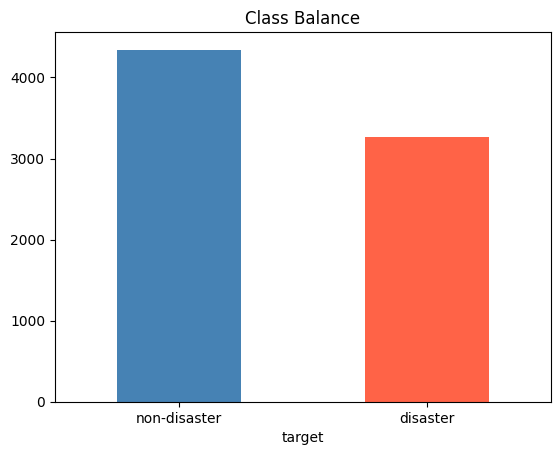


Example (target=0):
@AngusMacNeilSNP Every case for Yes has been utterly demolished utterly. If i was you IÛªd be embarrassed to bring up indy ever again. …

Example (target=1):
A poignant reminder that in war there are many casualties. http://t.co/Mwmt3BdR5L …


In [6]:
import os, pandas as pd
import matplotlib.pyplot as plt

BASE        = zip_path
TRAIN_CSV   = os.path.join(BASE, "train.csv")
TEST_CSV    = os.path.join(BASE, "test.csv")
SUB_CSV     = os.path.join(BASE, "sample_submission.csv")

train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
sub_df   = pd.read_csv(SUB_CSV)

print(train_df.shape, test_df.shape)
display(train_df.head())

# class balance
train_df.target.value_counts().plot.bar(color=["steelblue","tomato"])
plt.xticks([0,1], ["non‐disaster","disaster"], rotation=0)
plt.title("Class Balance"); plt.show()

# sample tweets
for t in [0,1]:
    print(f"\nExample (target={t}):")
    print(train_df[train_df.target==t].text.sample(1).iloc[0][:200], "…")

In [8]:
# Display the first few rows of the DataFrame
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


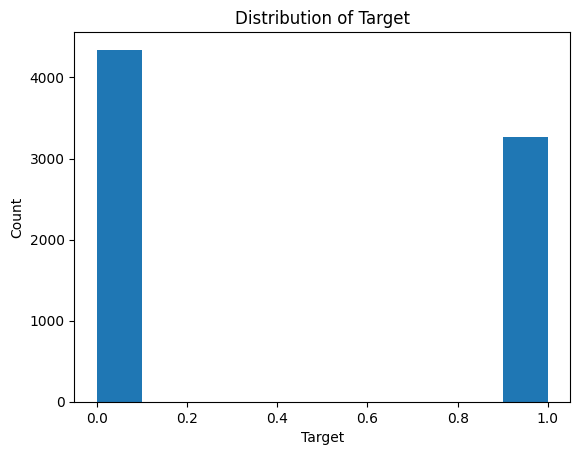

In [10]:
import matplotlib.pyplot as plt

# Plot a histogram of the target values
plt.hist(train_df['target'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target')
plt.show()

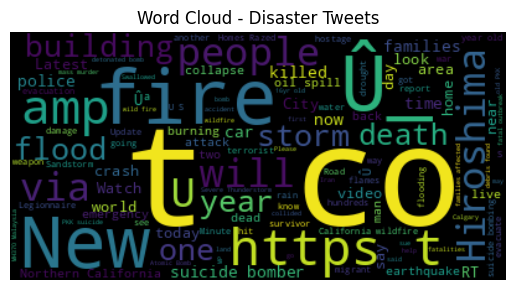

In [12]:
from wordcloud import WordCloud

# Generate word cloud for disaster-related tweets
disaster_tweets = train_df[train_df['target'] == 1]['text']
wordcloud = WordCloud().generate(' '.join(disaster_tweets))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Disaster Tweets')
plt.show()

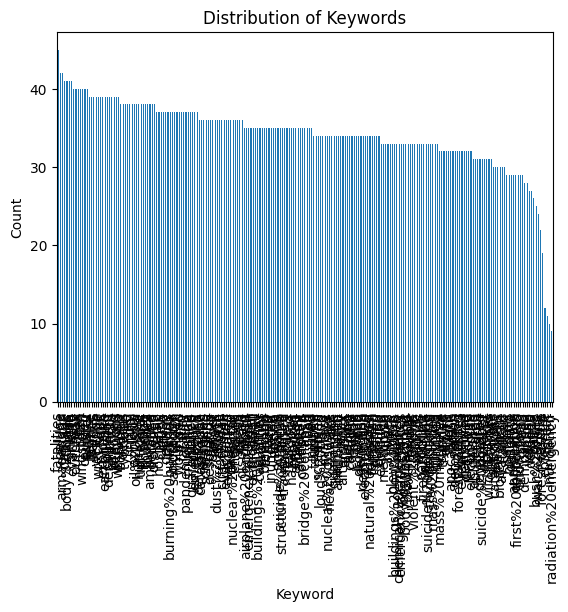

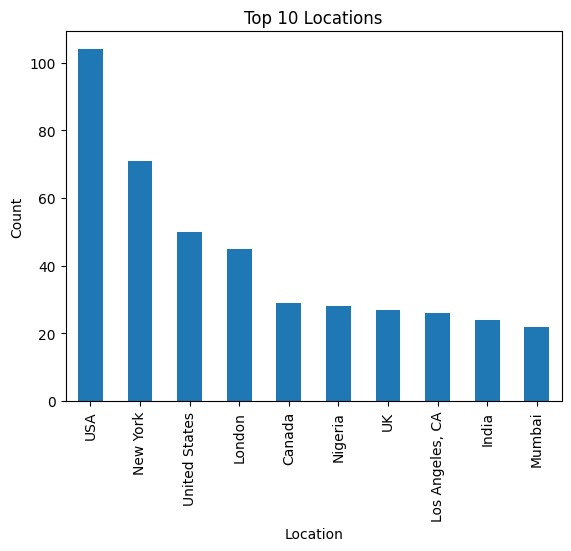

In [13]:
# Plot bar chart for keyword distribution
train_df['keyword'].value_counts().plot(kind='bar')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Distribution of Keywords')
plt.show()

# Plot bar chart for location distribution
train_df['location'].value_counts().head(10).plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Top 10 Locations')
plt.show()

In [16]:
# Check for missing values
print(train_df.isnull().sum())

# Remove rows with missing values
train_df = train_df.dropna()
# Double Check
print('missing values = ', train_df.isnull().sum().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
missing values =  0


In [17]:
# Convert text to lowercase
train_df['text'] = train_df['text'].str.lower()

### **Dataset Splitting**

In [18]:
# Split the dataset into training and validation sets
train_df, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

### **Text Preprocessing**

In [19]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

vocab_size = len(tokenizer.word_index) + 1

max_sequence_length = 100

train_sequences = tokenizer.texts_to_sequences(train_df['text'])
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')

val_sequences = tokenizer.texts_to_sequences(val_data['text'])
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')

### **Model Definition and Compilation**

In [21]:
# Define the deep learning model
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### **Model Training**

In [22]:
# Train the model
model.fit(train_padded_sequences, train_df['target'], validation_data=(val_padded_sequences, val_data['target']), epochs=10)

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.5708 - loss: 0.6871 - val_accuracy: 0.5709 - val_loss: 0.6832
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.5650 - loss: 0.6853 - val_accuracy: 0.5709 - val_loss: 0.6831
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 129ms/step - accuracy: 0.5806 - loss: 0.6801 - val_accuracy: 0.5709 - val_loss: 0.6832
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.5692 - loss: 0.6840 - val_accuracy: 0.5709 - val_loss: 0.6856
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.5678 - loss: 0.6855 - val_accuracy: 0.5709 - val_loss: 0.6832
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.5720 - loss: 0.6831 - val_accuracy: 0.5709 - val_loss: 0.6835
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.5450 - loss: 0.6893 - val_accuracy: 0.5709 - val_loss: 0.6833
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.5644 - loss: 0

### **Test Data Preprocessing**

In [23]:
# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

### **Generating Predictions and Creating Submission File**

In [24]:
# Generate predictions
predictions = model.predict(test_padded_sequences)
predictions = (predictions > 0.5).astype(int)

# Prepare submission file
submission = pd.DataFrame({'id': test_df['id'], 'target': predictions.flatten()})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step


## **Summary and Conclusions**

The accuracy remained around 56.69% for both the training and validation sets throughout all 10 epochs. The loss values also did not show significant changes.

This suggests that the model may have struggled to learn meaningful patterns from the data, as indicated by the consistently low accuracy. It is possible that the model is not capturing the complexities of the text data effectively or that the dataset itself lacks strong predictive features.

Further analysis and investigation are required to understand the reasons behind the model's limited performance. It may be beneficial to explore alternative model architectures, adjust hyperparameters, or gather more diverse and informative data to improve the model's accuracy.

Additionally, it is important to note that the validation accuracy remained constant at approximately 57.09% throughout the training process, which indicates that the model did not overfit the training data. However, the overall accuracy of 56.69% suggests that the model's predictions are not significantly better than random guessing.